In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
path = '../data/decesion-tree/风机结冰预测/train'
train_path = path + '/15'
pred_path = path + '/21'

In [23]:
train_data_raw = pd.read_csv(f'{train_path}/15_data.csv')
train_failInfo = pd.read_csv(f'{train_path}/15_failureInfo.csv')
train_normInfo = pd.read_csv(f'{train_path}/15_normalInfo.csv')
print(f'total: {len(train_data_raw)}')
print(f'fail num: {len(train_failInfo)}, norm num: {len(train_normInfo)}')

total: 393886
fail num: 29, norm num: 26


In [46]:
# train_data_raw.head()
train_failInfo.head(), train_normInfo.head()

(            startTime             endTime
 0 2015-11-04 21:37:00 2015-11-04 22:29:00
 1 2015-11-09 04:43:00 2015-11-09 06:35:00
 2 2015-11-09 21:21:00 2015-11-09 23:14:00
 3 2015-11-16 03:51:00 2015-11-16 11:06:00
 4 2015-11-16 14:15:00 2015-11-16 16:08:00,
             startTime             endTime
 0 2015-11-01 20:20:16 2015-11-03 23:47:32
 1 2015-11-04 14:04:51 2015-11-04 18:26:08
 2 2015-11-05 11:06:59 2015-11-09 02:44:31
 3 2015-11-09 12:30:09 2015-11-09 19:23:32
 4 2015-11-10 00:04:50 2015-11-15 23:03:06)

In [28]:
train_data_raw.time = pd.to_datetime(train_data_raw.time)
train_failInfo.startTime = pd.to_datetime(train_failInfo.startTime)
train_failInfo.endTime = pd.to_datetime(train_failInfo.endTime)
train_normInfo.startTime = pd.to_datetime(train_normInfo.startTime)
train_normInfo.endTime = pd.to_datetime(train_normInfo.endTime)

In [34]:
train_failInfo.head()
train_normInfo.head()

,startTime,endTime
0,2015-11-01 20:20:16,2015-11-03 23:47:32
1,2015-11-04 14:04:51,2015-11-04 18:26:08
2,2015-11-05 11:06:59,2015-11-09 02:44:31
3,2015-11-09 12:30:09,2015-11-09 19:23:32
4,2015-11-10 00:04:50,2015-11-15 23:03:06


In [55]:
def select_fail_norm(X: pd.DataFrame, failInfo: pd.DataFrame, normInfo: pd.DataFrame):
    fail_df = pd.DataFrame(columns=X.columns)
    for i in range(len(failInfo)):
        f = failInfo.iloc[i, :]
        temp = X[(X.time >= f.startTime) & (X.time <= f.endTime)]
        fail_df = pd.concat([fail_df, temp])

    norm_df = pd.DataFrame(columns=X.columns)
    for i in range(len(normInfo)):
        n = normInfo.iloc[i, :]
        temp = X[(X.time >= n.startTime) & (X.time <= n.endTime)]
        norm_df = pd.concat([norm_df, temp])
    fail_df['state'] = 1
    norm_df['state'] = 0
    return fail_df, norm_df

In [56]:
train_fail_raw, train_norm_raw = select_fail_norm(train_data_raw, train_failInfo, train_normInfo)
print(f'total: {len(train_data_raw)}')
print(f'fail num: {len(train_fail_raw)}, norm num: {len(train_norm_raw)}, invalid={len(train_data_raw) - len(train_fail_raw) - len(train_norm_raw)}')

total: 393886
fail num: 23846, norm num: 350255, invalid=19785


In [58]:
train_fail_raw.head()
train_norm_raw.head()

,time,wind_speed,generator_speed,power,wind_direction,wind_direction_mean,yaw_position,yaw_speed,pitch1_angle,pitch2_angle,...,environment_tmp,int_tmp,pitch1_ng5_tmp,pitch2_ng5_tmp,pitch3_ng5_tmp,pitch1_ng5_DC,pitch2_ng5_DC,pitch3_ng5_DC,group,state
6587,2015-11-04 21:37:06,1.295734,1.250185,1.115073,-0.80732,-1.601208,-0.684464,-0.00408,0.168889,0.208889,...,-0.056745,0.055075,0.86,0.706154,0.615385,-0.8,-0.36,0.52,61,1
6588,2015-11-04 21:37:13,1.199847,1.256833,1.044981,-0.665759,-0.603176,-0.684464,-0.038964,0.168889,0.208889,...,-0.056745,0.055075,0.86,0.706154,0.615385,1.88,-0.52,1.28,61,1
6589,2015-11-04 21:37:23,1.210911,1.26348,1.048988,-1.040378,-2.083759,-0.67864,0.100571,0.168889,0.208889,...,-0.056745,0.055075,0.86,0.721538,0.629231,-0.4,0.44,2.0,61,1
6590,2015-11-04 21:37:30,1.332614,1.256833,1.030967,-0.950608,0.83941,-0.684464,-0.00408,0.168889,0.208889,...,-0.074104,0.055075,0.846154,0.738462,0.629231,-0.44,1.24,-0.4,61,1
6591,2015-11-04 21:37:37,1.590772,1.26348,1.028952,-1.000672,-0.727297,-0.684464,-0.038964,0.168889,0.208889,...,-0.056745,0.055075,0.846154,0.738462,0.629231,-0.36,1.04,2.24,61,1


In [59]:
from sklearn.model_selection import train_test_split, cross_val_score
def split_train_val(X):
    x_train, x_val = train_test_split(X, test_size=0.3, shuffle=True)
    return x_train, x_val

In [65]:
train_fail_raw_train, train_fail_raw_val = split_train_val(train_fail_raw)
train_norm_raw_train, train_norm_raw_val = split_train_val(train_norm_raw)

In [66]:
from sklearn.utils import shuffle
data_raw_train = shuffle(pd.concat([train_fail_raw_train, train_norm_raw_train]))
data_raw_val = shuffle(pd.concat([train_fail_raw_val, train_norm_raw_val]))

In [74]:
from sklearn.tree import DecisionTreeClassifier
baseline_model = DecisionTreeClassifier()
baseline_model.fit(data_raw_train.iloc[:, 1:-1], data_raw_train.iloc[:, -1])
score = cross_val_score(baseline_model, data_raw_val.iloc[:, 1:-1], data_raw_val.iloc[:, -1]).mean()
score

0.9988060328716492

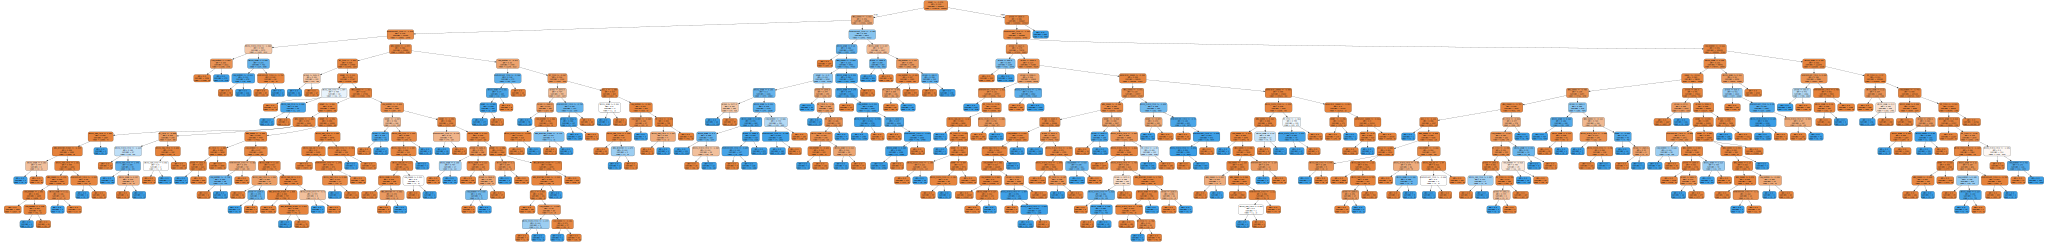

<Figure size 1440x1440 with 0 Axes>

In [82]:
import graphviz
from sklearn import tree
feat_names = list(data_raw_train.columns)
# class_names = ['Norm', 'Fail']
plt.figure(figsize=(20, 20))
graph = tree.export_graphviz(baseline_model, filled=True, rounded=True, feature_names=feat_names[1:-1])
graph =graphviz.Source(graph)
graph

In [94]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def evaluate(model, X, y_true):
    y_pred = model.predict(X)
    cf_matrix = confusion_matrix(y_true, y_pred)
    pred_score = precision_score(y_true, y_pred)
    pred_recall = recall_score(y_true, y_pred)
    return cf_matrix, (pred_score, pred_recall)

(0.998040313549832, 0.9966452334358401)


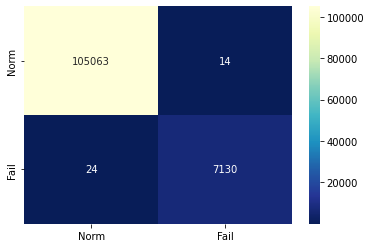

In [95]:
class_names = ['Norm', 'Fail']
cf_matrix, pred_score = evaluate(baseline_model, data_raw_val.iloc[:, 1:-1], data_raw_val.iloc[:, -1])
sns.heatmap(pd.DataFrame(cf_matrix, columns=class_names, index=class_names), cmap="YlGnBu_r", fmt="d", annot=True)
print(pred_score)